In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("/home/alexander/projects/car_data_analysis/repeat_mini_proj_1/all_ads_w_omit_and_ranger.csv")
data.head()

,Unnamed: 0,mileage,manufactured.year,engine.size,owners,desc,price,make,id,age,ranger_predict
0,1,149000.0,2003,1.6,8,"12mths mot, good tyres and just been serviced ...",800,Volkswagen,aa8fd5ada99a4098beca3c64ab7a62e5,18,1100.019033
1,2,115000.0,2005,1.6,5,Spares or Repair! My partners lovely car just ...,750,Volkswagen,e2c0072eed0e4ac7b81b8d6fdb60c37b,16,1173.489300
2,3,61000.0,2003,1.4,4,Low mileage car with working electric roof. Pi...,395,Citroen,84145e24c05b489984dded1a4af6454d,18,700.731300
3,4,65659.0,2005,1.6,5,A fun covertable car. Fair size boot. Selling ...,500,Ford,bbbd3061dfe84638a772d1abdd210824,16,1038.943733
4,5,143510.0,2004,1.6,5,Bought this direct from my mechanic a year ago...,800,MINI,d22536078bb842edbee16f654462b580,17,1205.553133


In [3]:
factors = set(data["make"].values)

data = data.sample(frac=1)
print(factors)
data.head()

{'Citroen', 'Jeep', 'Toyota', 'Fiat', 'Ford', 'Subaru', 'MINI', 'MG', 'Chrysler', 'Smart', 'Mazda', 'Vauxhall', 'Chevrolet', 'Dacia', 'Renault', 'Land Rover', 'Saab', 'Hyundai', 'Lexus', 'Suzuki', 'BMW', 'Volkswagen', 'Audi', 'DS AUTOMOBILES', 'Nissan', 'Kia', 'Honda', 'Peugeot', 'SEAT', 'Jaguar', 'SKODA', 'SsangYong', 'Mercedes-Benz', 'Daihatsu', 'Abarth', 'Volvo', 'Rover', 'Porsche', 'Mitsubishi', 'Alfa Romeo'}


,Unnamed: 0,mileage,manufactured.year,engine.size,owners,desc,price,make,id,age,ranger_predict
16877,27517,114000.0,2006,1.6,3,"I've owned this car for 6 years, always been r...",775,Vauxhall,56b398e3a7334b5aa918cb5eb03f5f90,15,847.134352
12852,20307,7018.0,2008,1.3,2,"Low mileage, all new tyres in 2015, new batter...",2673,Suzuki,cc5215c6f243479da5dd772450c9a591,13,3105.770800
6637,10676,43063.0,2013,1.4,2,"FULL SERVICE HISTORY, LAST SERVICED @42K MILES...",8990,Volkswagen,06cc30330036432fb438298f252d14b8,8,7755.754567
25269,41388,31745.0,2016,1.6,1,"OPEN FOR CLICK & COLLECT & HOME DELIVERY..., W...",8489,Peugeot,29699383baaf48a09fa5793088c305fc,5,7830.109067
6920,11125,219000.0,2006,2.0,5,Reluctantly selling my BMW estate. Selling as...,1695,BMW,d45e87c9f6764abab00b7578add7b576,15,1802.019900


In [4]:
non_make_cols = ["mileage","age", "engine.size","owners"]
make_col = ["make"]
price_col = ["price"]


# Perform splitting in fit
train_makes, train_prices, train_input = data[make_col].values.flatten(), data[price_col].values, data[non_make_cols].values
assert not np.any(np.isnan(train_input))
assert not np.any(np.isnan(train_prices))

In [331]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode='tf-idf', split=None)
encoder.adapt(data["make"].values)

make_input = tf.keras.Input(shape=(1,), dtype=tf.string, name="make")
x = encoder(make_input)

reg = keras.regularizers.L2(l2=0.2)
init = keras.initializers.HeUniform()

def round_to(base):
    def round(x):
        return tf. multiply(base, tf.round(tf.divide(x,base)) )

other_input = keras.Input(shape=(4,), name="other")
x = layers.concatenate([x, other_input])
x = layers.Dense(64)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(128, 
#                  activation="relu", 
#                  kernel_regularizer=reg,
#                 kernel_initializer=init
#                 )(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(128, 
#                  activation="relu", 
#                  kernel_regularizer=reg,
#                 kernel_initializer=init
#                 )(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(64, 
#                  activation="relu", 
#                  kernel_regularizer=reg,
#                 kernel_initializer=init
#                 )(x)
# x = layers.BatchNormalization()(x)
x = layers.Dense(1)(x)
x = layers.Activation(round_to(500))(x)
net = layers.LeakyReLU(1, name="price")(x)

model = keras.Model([make_input,other_input],net)

Model: "functional_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
make (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_60 (TextVect (None, 41)           0           make[0][0]                       
__________________________________________________________________________________________________
other (InputLayer)              [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate_59 (Concatenate)    (None, 45)           0           text_vectorization_60[0][0]      
                                                                 other[0][0]         

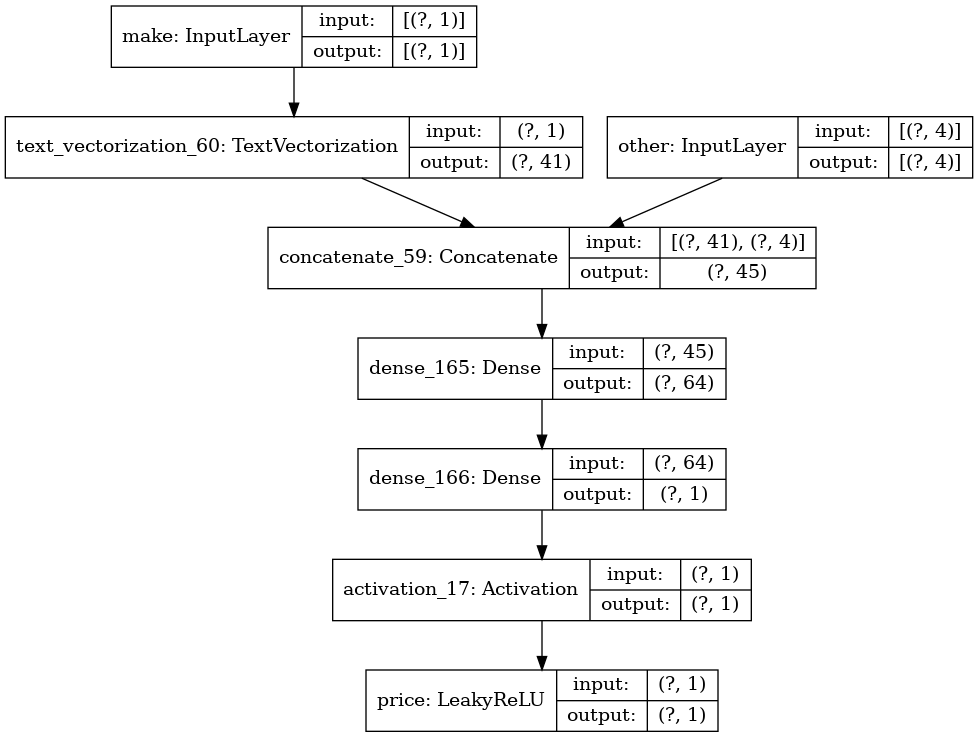

In [332]:
boundaries = [20,30,50]
values = [1e-4, 1e-5,1e-6,1e-7]
lr = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)


sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1, nesterov=False, name='SGD')

class MeanQuadError(keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.math.square(tf.math.square(y_pred - y_true)), axis=-1)

loss = keras.losses.MeanSquaredError()


model.compile(loss='mse')

model.summary()
keras.utils.plot_model(model, "helper_plot.png", show_shapes=True)
# model.evaluate((train_makes[0:32], train_input[0:32]), train_prices[0:32])

In [333]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history = model.fit([train_makes, train_input], 
                    train_prices,
                    epochs=100,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping]
                   )

Epoch 1/100
758/758 [==============================] - 4s 5ms/step - loss: 15529671.0000 - val_loss: 15531837.0000
Epoch 2/100
758/758 [==============================] - 4s 5ms/step - loss: 15302328.0000 - val_loss: 17134374.0000
Epoch 3/100
758/758 [==============================] - 3s 4ms/step - loss: 15159982.0000 - val_loss: 17142666.0000
Epoch 4/100
758/758 [==============================] - 4s 5ms/step - loss: 15063355.0000 - val_loss: 15087405.0000
Epoch 5/100
758/758 [==============================] - 3s 4ms/step - loss: 15009772.0000 - val_loss: 17376060.0000
Epoch 6/100
758/758 [==============================] - 3s 4ms/step - loss: 14800131.0000 - val_loss: 14928437.0000
Epoch 7/100
758/758 [==============================] - 3s 4ms/step - loss: 14739397.0000 - val_loss: 15205095.0000
Epoch 8/100
758/758 [==============================] - 3s 5ms/step - loss: 14616101.0000 - val_loss: 15745759.0000
Epoch 9/100
758/758 [==============================] - 4s 5ms/step - loss: 14518

Epoch 72/100
758/758 [==============================] - 3s 4ms/step - loss: 9486633.0000 - val_loss: 7503034.5000
Epoch 73/100
758/758 [==============================] - 4s 5ms/step - loss: 9350484.0000 - val_loss: 13171254.0000
Epoch 74/100
758/758 [==============================] - 4s 5ms/step - loss: 9358348.0000 - val_loss: 7247196.0000
Epoch 75/100
758/758 [==============================] - 4s 5ms/step - loss: 9241119.0000 - val_loss: 7391510.5000
Epoch 76/100
758/758 [==============================] - 3s 4ms/step - loss: 9195261.0000 - val_loss: 7709134.0000
Epoch 77/100
758/758 [==============================] - 4s 5ms/step - loss: 9158242.0000 - val_loss: 13154262.0000
Epoch 78/100
758/758 [==============================] - 4s 5ms/step - loss: 9154578.0000 - val_loss: 7567819.0000
Epoch 79/100
758/758 [==============================] - 4s 5ms/step - loss: 9131391.0000 - val_loss: 7392936.0000
Epoch 80/100
758/758 [==============================] - 4s 5ms/step - loss: 9041271.00

In [288]:
import matplotlib.pyplot as plt

def plot(model, title):
    truth = data["price"]
    preds = model.predict({'make':train_makes, 'other':train_input})[:,0]
    
    r_squared = 1 - np.sum((truth - preds)**2)/np.sum((truth-np.mean(truth))**2)
    
    plt.figure(figsize=(8,8))
    fig, ax = plt.subplots(nrows=2,ncols=2)
    ax[0,0].hist2d(truth, preds, bins=50)
    ax[0,0].plot(truth, truth, color="white")

    ax[0,1].scatter(truth, preds, color="red", alpha=0.2)
    ax[0,1].plot(truth, truth, color="black")

    _, bins, _ = ax[1,0].hist(truth, bins=50, alpha=0.4)
    ax[1,0].hist(preds, bins=bins, alpha=0.4)
    
    ax[1,1].hist(truth-preds, bins=50, alpha=0.4)

    fig.suptitle(title + f'\n$R^2$:{r_squared:.2f}')
    fig.tight_layout(pad=2)
    

<Figure size 576x576 with 0 Axes>

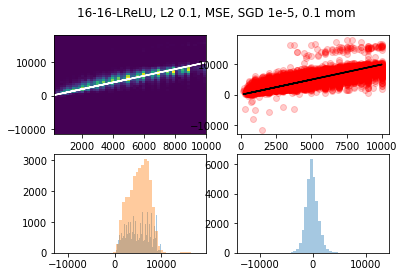

In [129]:
title = '16-16-LReLU, L2 0.1, MSE, SGD 1e-5, 0.1 mom'
plot(model, title)
plt.savefig(title+'.png')

<Figure size 576x576 with 0 Axes>

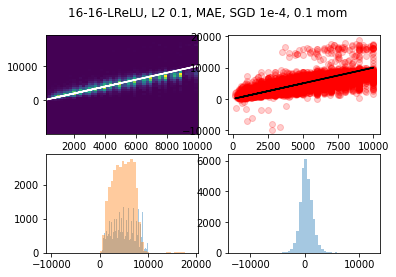

In [134]:
# training more stable
title = '16-16-LReLU, L2 0.1, MAE, SGD 1e-4, 0.1 mom'
plot(model, title)
plt.savefig(title+'.png')

<Figure size 576x576 with 0 Axes>

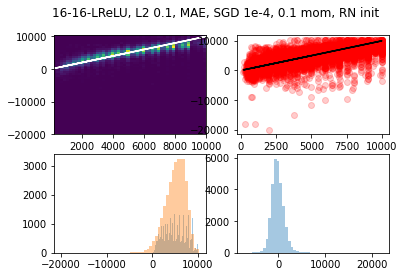

In [157]:
title = '16-16-LReLU, L2 0.1, MAE, SGD 1e-4, 0.1 mom, RN init'
plot(model, title)

<Figure size 576x576 with 0 Axes>

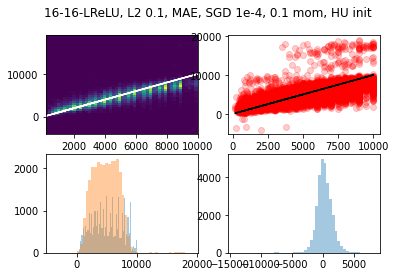

In [163]:
title = '16-16-LReLU, L2 0.1, MAE, SGD 1e-4, 0.1 mom, HU init'
plot(model, title)

<Figure size 576x576 with 0 Axes>

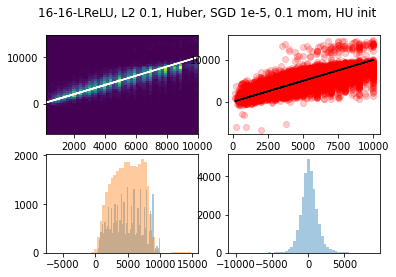

In [183]:
title = '16-16-LReLU, L2 0.1, Huber, SGD 1e-5, 0.1 mom, HU init'
plot(model, title)

<Figure size 576x576 with 0 Axes>

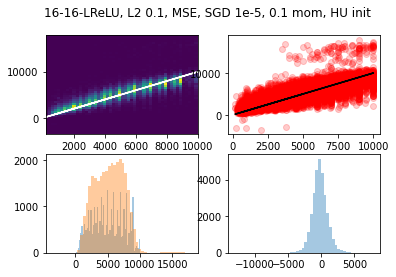

In [189]:
title = '16-16-LReLU, L2 0.1, MSE, SGD 1e-5, 0.1 mom, HU init'
plot(model, title)

<Figure size 576x576 with 0 Axes>

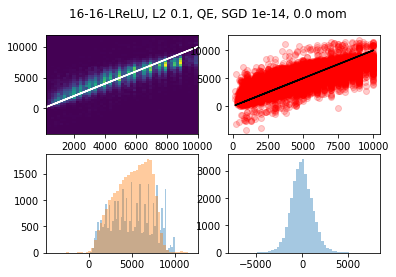

In [242]:
title = '16-16-LReLU, L2 0.1, QE, SGD 1e-14, 0.0 mom'
plot(model, title)

<Figure size 576x576 with 0 Axes>

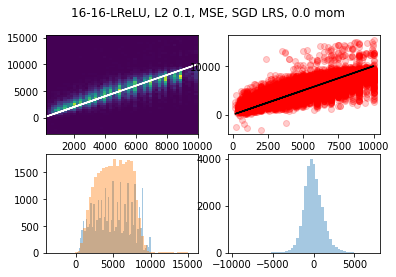

In [254]:
title = '16-16-LReLU, L2 0.1, MSE, SGD LRS, 0.0 mom'
plot(model, title)

<Figure size 576x576 with 0 Axes>

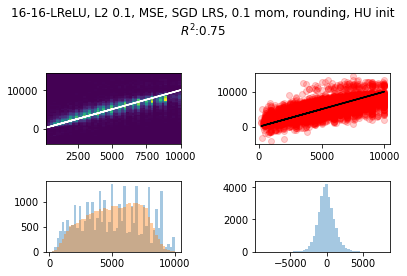

In [293]:
title = '16-16-LReLU, L2 0.1, MSE, SGD LRS, 0.1 mom, rounding 50, HU init'
plot(model, title)

<Figure size 576x576 with 0 Axes>

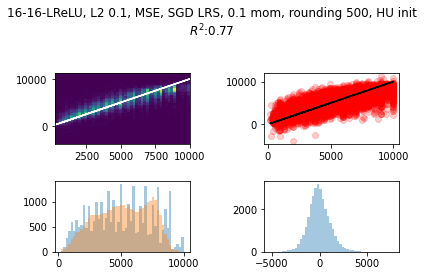

In [297]:
title = '16-16-LReLU, L2 0.1, MSE, SGD LRS, 0.1 mom, rounding 500, HU init'
plot(model, title)

<Figure size 576x576 with 0 Axes>

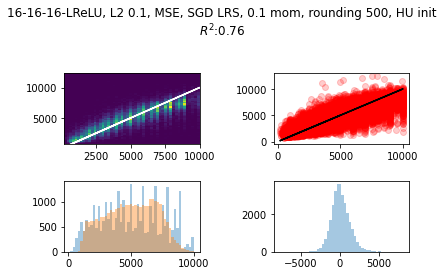

In [301]:
title = '16-16-16-LReLU, L2 0.1, MSE, SGD LRS, 0.1 mom, rounding 500, HU init'
plot(model, title)